# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S3E25 - Mohs Hardness</p>

In [1]:
# %load ../utils/config.py
!pip install -q kaleido
import glob
import operator
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime
!pip install --upgrade scikit-learn

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.display import HTML, Image, display_html
from lightgbm import LGBMClassifier, LGBMRegressor
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn import clone
from sklearn.base import (
    BaseEstimator,
    ClassNamePrefixFeaturesOutMixin,
    MetaEstimatorMixin,
    OneToOneFeatureMixin,
    TransformerMixin,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (
    GradientBoostingRegressor,
    IsolationForest,
    RandomForestRegressor,
)
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.metrics import (
    confusion_matrix,
    median_absolute_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.pipeline import FunctionTransformer, make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils.validation import check_array, check_is_fitted
from xgboost import XGBClassifier

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Data Frame and Plotly colors.
FONT_COLOR = "#8c564b"
BACKGROUND_COLOR = "#FFFCFA"
GRADIENT_COLOR = "#17becf"
COLOR_SCHEME = np.array(("#8c564b", "#FFFCFA", "#17becf"))
TICKSIZE = 11

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_family="Open Sans",
        font_color=FONT_COLOR,
        title_font_size=20,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        yaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        width=840,
        height=540,
        legend=dict(yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 14,
    "axes.grid": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 14,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    "font.family": "Serif",
}
sns.set_theme(rc=MATPLOTLIB_THEME)

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `None`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    if data_dir is None:
        data_dir = Path("data/")
    else:
        data_dir = Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return [interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1)]


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99))
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    missing_vals = frame.isna().sum()
    missing_vals_ratio = missing_vals / len(frame)
    unique_vals = frame.apply(lambda col: len(col.unique()))
    most_freq_count = frame.apply(lambda col: col.value_counts().iloc[0])
    most_freq_val = frame.mode().iloc[:1].T.squeeze()
    unique_ratio = unique_vals / len(frame)
    freq_count_ratio = most_freq_count / len(frame)

    return pd.DataFrame(
        {
            "Dtype": frame.dtypes,
            "MissingValues": missing_vals,
            "MissingValuesRatio": missing_vals_ratio,
            "UniqueValues": unique_vals,
            "UniqueValuesRatio": unique_ratio,
            "MostFreqValue": most_freq_val,
            "MostFreqValueCount": most_freq_count,
            "MostFreqValueCountRatio": freq_count_ratio,
        }
    )


def check_categories_alignment(frame1, frame2, /, out_color=BLUE):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = frame2.select_dtypes(include="object").columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].unique())
        frame2_unique = set(frame2[feature].unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:25s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
    if img_dir is None:
        img_dir = Path("images")
    if not isinstance(img_dir, Path):
        raise TypeError("The `img_dir` argument must be `Path` instance!")

    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)

    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


def unit_norm(x):
    return x / np.sum(x)


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/d0/0b/26ad95cf0b747be967b15fb71a06f5ac67aba0fd2f9cd174de6edefc4674/scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 51.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [2]:
competition = "playground-series-s3e25"
expr = f"kaggle competitions download -c {competition}"

if not ON_KAGGLE:
    download_from_kaggle(expr)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id")  # .rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id")  # .rename(columns=str.title)

In [3]:
get_pretty_frame(train.head())

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.000,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100.000,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76.000,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100.000,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116.000,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000


In [4]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Columns: 12 entries, allelectrons_Total to Hardness
dtypes: float64(12)
memory usage: 1.0 MB


In [5]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 6939 entries, 10407 to 17345
Columns: 11 entries, allelectrons_Total to density_Average
dtypes: float64(11)
memory usage: 650.5 KB


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

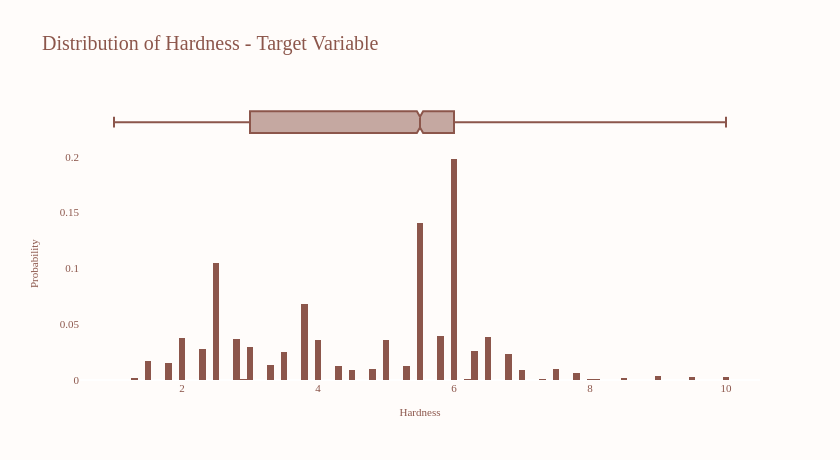

In [6]:
fig = px.histogram(
    train,
    x="Hardness",
    histnorm="probability",
    marginal="box",
    height=460,
    title="Distribution of Hardness - Target Variable"
       )
fig.update_yaxes(title="Probability", row=1)
save_and_show_fig(fig, "hardness_distribution")

In [7]:
print(CLR + "Training Dataset:")
train_summary = frame_summary(train)
get_pretty_frame(train_summary, gradient=True)

Training Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
allelectrons_Total,float64,0,0.000,325,0.031,100.000,822,0.079
density_Total,float64,0,0.000,1099,0.106,8.148,237,0.023
allelectrons_Average,float64,0,0.000,629,0.060,10.000,1602,0.154
val_e_Average,float64,0,0.000,205,0.020,4.800,2858,0.275
atomicweight_Average,float64,0,0.000,849,0.082,20.299,316,0.030
ionenergy_Average,float64,0,0.000,898,0.086,11.330,354,0.034
el_neg_chi_Average,float64,0,0.000,745,0.072,2.706,289,0.028
R_vdw_element_Average,float64,0,0.000,737,0.071,1.717,274,0.026
R_cov_element_Average,float64,0,0.000,698,0.067,0.910,344,0.033
zaratio_Average,float64,0,0.000,815,0.078,0.493,267,0.026


In [8]:
print(CLR + "Test Dataset:")
test_summary = frame_summary(test)
get_pretty_frame(test_summary, gradient=True)

Test Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
allelectrons_Total,float64,0,0.000,263,0.038,100.000,593,0.085
density_Total,float64,0,0.000,904,0.130,7.558,165,0.024
allelectrons_Average,float64,0,0.000,514,0.074,10.000,1094,0.158
val_e_Average,float64,0,0.000,185,0.027,4.800,1939,0.279
atomicweight_Average,float64,0,0.000,728,0.105,20.299,223,0.032
ionenergy_Average,float64,0,0.000,699,0.101,11.330,254,0.037
el_neg_chi_Average,float64,0,0.000,643,0.093,2.706,230,0.033
R_vdw_element_Average,float64,0,0.000,622,0.090,1.742,186,0.027
R_cov_element_Average,float64,0,0.000,592,0.085,0.910,240,0.035
zaratio_Average,float64,0,0.000,660,0.095,0.493,171,0.025



  Missing  Unique Most Frequent Values

   * What's surprising there is no missing values, so we don't need to bother about imputation. We can see the ratio of unique values in both datasets is quite low for all features, which means that features consist of many repeatable values. This makes them more semi-continuous rather than continuous. The target variable has only $50$ unique values among more than $10000$ training samples.


In [9]:
print(CLR + "Training Dataset:")
train_num_descr = numeric_descr(train)
get_pretty_frame(train_num_descr, gradient=True)

Training Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
allelectrons_Total,128.054,224.124,0.000,6.000,36.000,68.000,100.000,131.000,278.000,719.400,15300.000
density_Total,14.491,15.973,0.000,0.740,2.333,7.558,10.650,16.677,37.007,75.099,643.094
allelectrons_Average,17.033,10.469,0.000,4.667,7.500,10.000,12.600,22.000,42.000,50.000,67.000
val_e_Average,4.547,0.691,0.000,2.000,3.500,4.000,4.714,4.800,5.600,5.667,6.000
atomicweight_Average,37.508,26.012,0.000,8.773,14.997,20.299,26.204,48.719,98.341,119.629,167.400
ionenergy_Average,10.938,1.408,0.000,8.054,9.014,10.591,11.203,11.671,12.373,13.513,15.246
el_neg_chi_Average,2.608,0.335,0.000,1.790,2.045,2.530,2.706,2.805,2.902,2.980,3.443
R_vdw_element_Average,1.731,0.192,0.000,1.319,1.518,1.673,1.733,1.800,1.943,2.055,2.250
R_cov_element_Average,0.944,0.180,0.000,0.505,0.708,0.864,0.916,0.982,1.233,1.390,1.616
zaratio_Average,0.493,0.063,0.000,0.405,0.448,0.476,0.489,0.496,0.616,0.707,0.826


In [10]:
print(CLR + "Test Dataset:")
test_num_descr = numeric_descr(test)
get_pretty_frame(test_num_descr, gradient=True)

Test Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
allelectrons_Total,126.460,207.564,0.000,14.000,33.000,68.000,100.000,128.000,278.000,710.000,10116.000
density_Total,14.794,18.982,0.000,0.772,2.333,7.558,10.650,16.601,37.777,105.514,643.094
allelectrons_Average,17.406,10.996,0.000,4.667,7.500,10.000,12.667,22.000,42.800,50.000,67.000
val_e_Average,4.547,0.683,0.000,2.025,3.500,4.000,4.750,4.800,5.600,5.800,6.000
atomicweight_Average,38.423,27.344,0.000,8.773,14.997,20.299,26.204,48.719,103.499,119.629,167.400
ionenergy_Average,10.922,1.379,0.000,8.054,8.917,10.584,11.203,11.646,12.302,13.513,15.246
el_neg_chi_Average,2.608,0.323,0.000,1.903,2.045,2.527,2.706,2.807,2.902,2.980,3.443
R_vdw_element_Average,1.738,0.191,0.000,1.319,1.542,1.678,1.736,1.820,1.980,2.087,2.250
R_cov_element_Average,0.950,0.179,0.000,0.520,0.710,0.867,0.920,0.990,1.253,1.390,1.615
zaratio_Average,0.492,0.061,0.000,0.403,0.446,0.476,0.489,0.496,0.614,0.696,0.826


## Adversarial Validation
Let's test the last consideration with adversarial validation. What is the adversarial validation? Well, it's a very straightforward way to check whether our subsets are similar (sampled from the same or very similar distributions).We label training and test datasets with, for example, $0$ and $1$. Then, we combine them into one dataset and shuffle them. Subsequently, we can perform binary classification and assess if we're able to identify which observation is from which dataset. When we get a ROC value of around $0.5$ (random guessing), they are indistinguishable, and this case is desired. On the other hand, when ROC $>0.5$, it probably means that training and test subsets are from different distributions.


In [11]:
train_av = train.drop("Hardness", axis=1).assign(AV=0)
test_av = test.assign(AV=1)

data_av = pd.concat((train_av, test_av), ignore_index=True)
data_av = data_av.sample(frac=1.0, random_state=42)

X = data_av.drop("AV", axis=1)
y = data_av.AV

y_proba = cross_val_predict(
    estimator=make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    X=X,
    y=y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=19937),
    method="predict_proba",
)

av_scores = {
    "ConfusionMatrix": confusion_matrix(y, y_proba.argmax(axis=1)),
    "FPR-TPR-Threshold": roc_curve(y, y_proba[:, 1]),
    "ROC-AUC": roc_auc_score(y, y_proba[:, 1]),
}

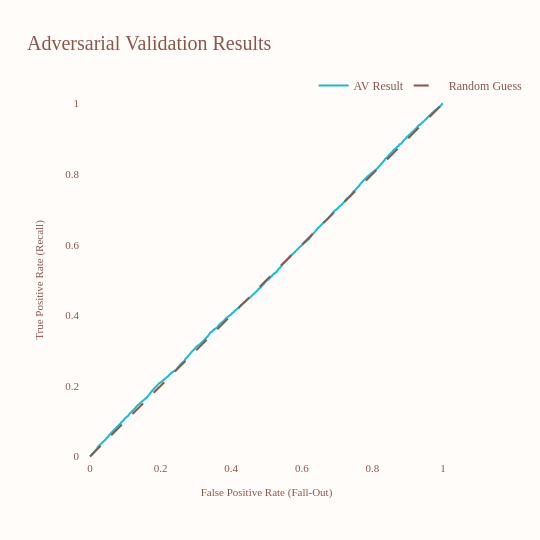

In [12]:
fig = go.Figure()
fig.add_scatter(
    x=av_scores["FPR-TPR-Threshold"][0],
    y=av_scores["FPR-TPR-Threshold"][1],
    name="AV Result",
    mode="lines",
    line_color=COLOR_SCHEME[2],
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="Random Guess",
    mode="lines",
    line=dict(dash="longdash", color=COLOR_SCHEME[0]),
)

fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
)
fig.update_layout(
    title="Adversarial Validation Results",    
    width=540,
    legend=dict(y=1.0, x=1.2),
)
save_and_show_fig(fig, "adversarial_validation")

Adversarial Validation Results
* So, the result is excellent for us since ROC $\approx 0.5$ means that subsets are indistinguishable (they come from the same distribution).


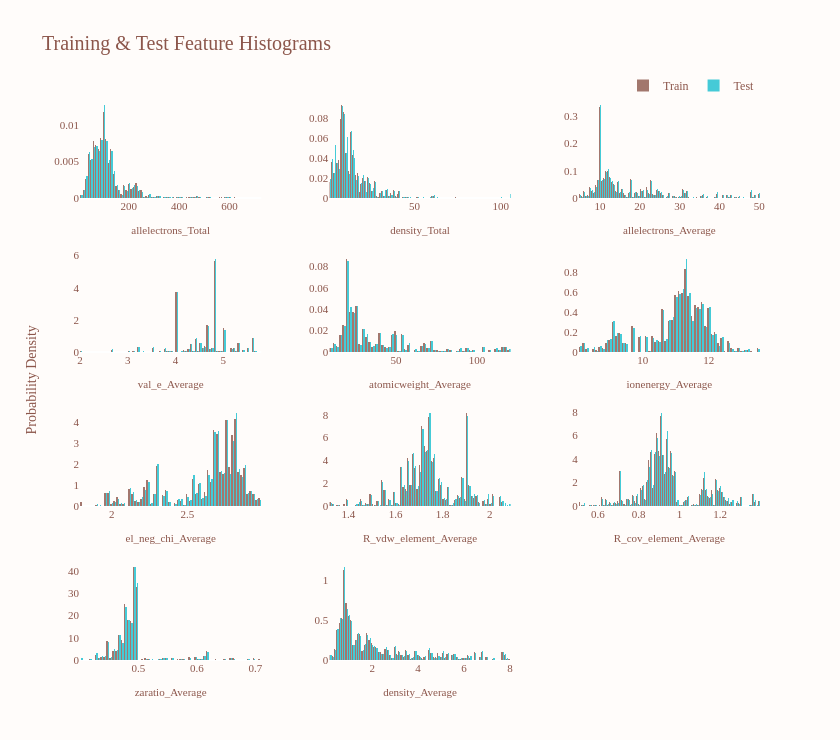

In [13]:
features = test.columns.to_list()

n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train, test), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        start, end = np.percentile(frame[var], (1, 99))
        fig.add_histogram(
            x=frame[var],
            xbins=go.histogram.XBins(start=start, end=end),
            histnorm="probability density",
            marker_color=color,
            marker_line_width=0,
            opacity=0.8,
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"{var}", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature Histograms",
    bargap=0,
    bargroupgap=0,
)
save_and_show_fig(fig, "histograms")

All the features also indistinguisable between train and test set.

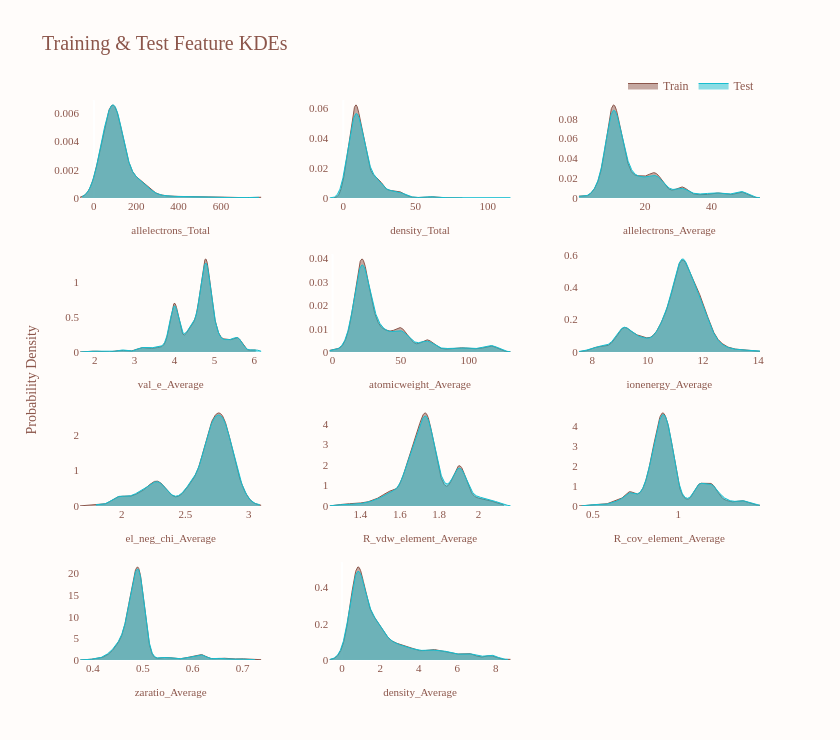

In [14]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train, test), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        kde = get_kde_estimation(frame[var], percentile_range=(1, 99))
        fig.add_scatter(
            x=kde["space"],
            y=kde["vals"],
            line=dict(dash="solid", color=color, width=1),
            fill="tozeroy",
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"{var}", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature KDEs"
    ,
)
save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions confirm the previous statement, i.e. training and test subsets probably follow the same distribution, which is reflected as bins overlapping and similar density estimation. Let's continue analysis with correlation matrix and hierarchical clustering. 
</p>

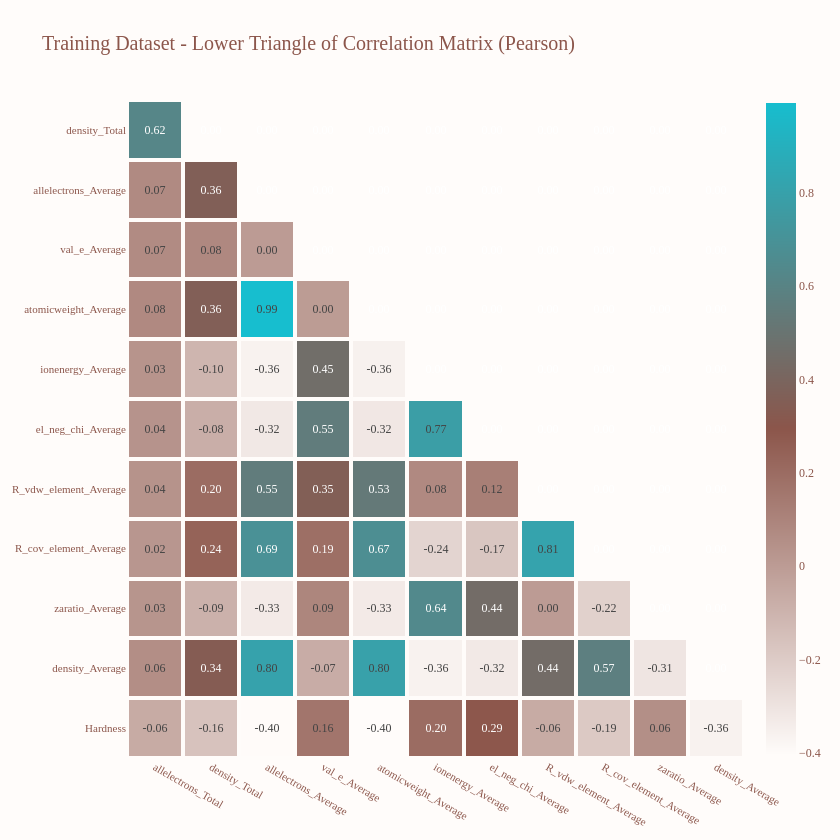

In [15]:
pearson_corr = train.corr(method="pearson")
lower_triu_corr = get_lower_triangular_frame(pearson_corr)
colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[1, 0, 2]]))

heatmap = go.Heatmap(
    z=lower_triu_corr,
    x=lower_triu_corr.columns,
    y=lower_triu_corr.index,
    text=lower_triu_corr.fillna(""),
    texttemplate="%{text:.2f}",
    xgap=4,
    ygap=4,
    showscale=True,
    colorscale=colormap,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Training Dataset - Lower Triangle of Correlation Matrix (Pearson)",
    yaxis_autorange="reversed",
    width=840,
    height=840,
)
save_and_show_fig(fig, "pearson_corr_matrix")

In [16]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

                Feature 1              Feature 2  Absolute Pearson Correlation
0    allelectrons_Average   atomicweight_Average                       0.99066
1   R_vdw_element_Average  R_cov_element_Average                       0.81182
2    allelectrons_Average        density_Average                       0.80364
3    atomicweight_Average        density_Average                       0.79656
4       ionenergy_Average     el_neg_chi_Average                       0.77405
..                    ...                    ...                           ...
61     allelectrons_Total        zaratio_Average                       0.03104
62     allelectrons_Total  R_cov_element_Average                       0.02442
63   allelectrons_Average          val_e_Average                       0.00438
64  R_vdw_element_Average        zaratio_Average                       0.00298
65          val_e_Average   atomicweight_Average                       0.00186

[66 rows x 3 columns]


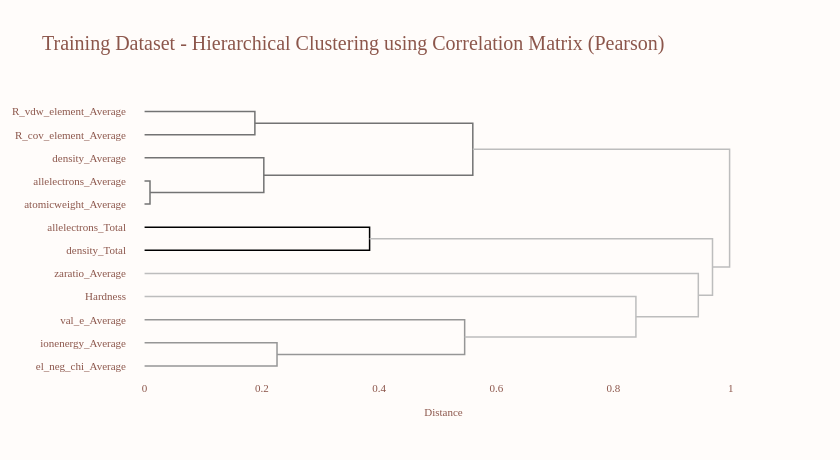

In [17]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[3:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.03, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Pearson)<br>",
    height=460,
    width=840,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

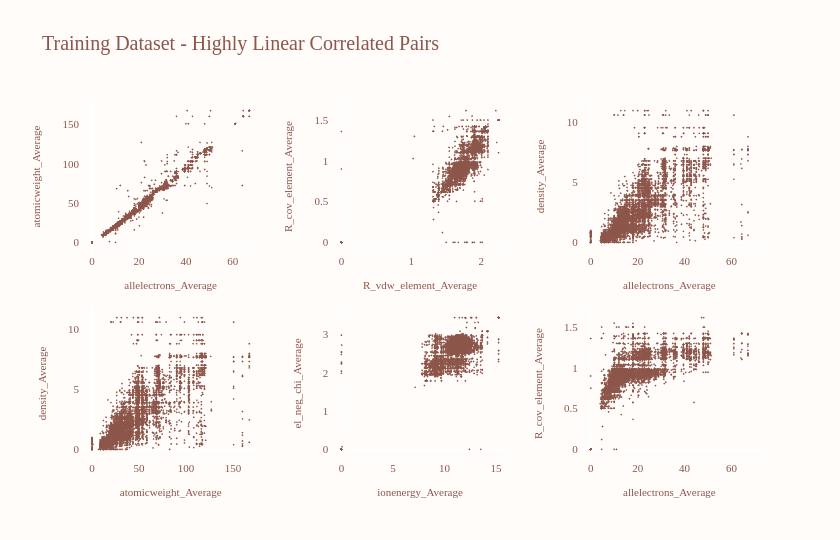

In [18]:
n_cols, n_features = 3, 6
n_rows, axes = get_n_rows_and_axes(n_features, n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    horizontal_spacing=0.1,
    vertical_spacing=0.15,
)

for (row, col), (feature1, feature2, corr) in zip(axes, abs_corr[:n_features].to_numpy()):
    fig.add_scatter(
        x=train[feature1],
        y=train[feature2],
        mode="markers",
        name="",
        row=row,
        col=col,
    )
    fig.update_xaxes(title_text=feature1, row=row, col=col)
    fig.update_yaxes(title_text=feature2, row=row, col=col)

fig.update_layout(
    title="Training Dataset - Highly Linear Correlated Pairs",
    width=840,
    height=540,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
)
save_and_show_fig(fig, "highly_correlated_scatter_plots")

Highly Linear Correlated Pairs

* So, as we can see, there is a clearly visible high correlation between <code>allelectrons_Average</code> and <code>atomicweight_Average</code>. On the other hand, it's hard to say something about <code>ionenergy_Average</code> and <code>el_neg_chi_Average</code> because zero-points warp the correlation.


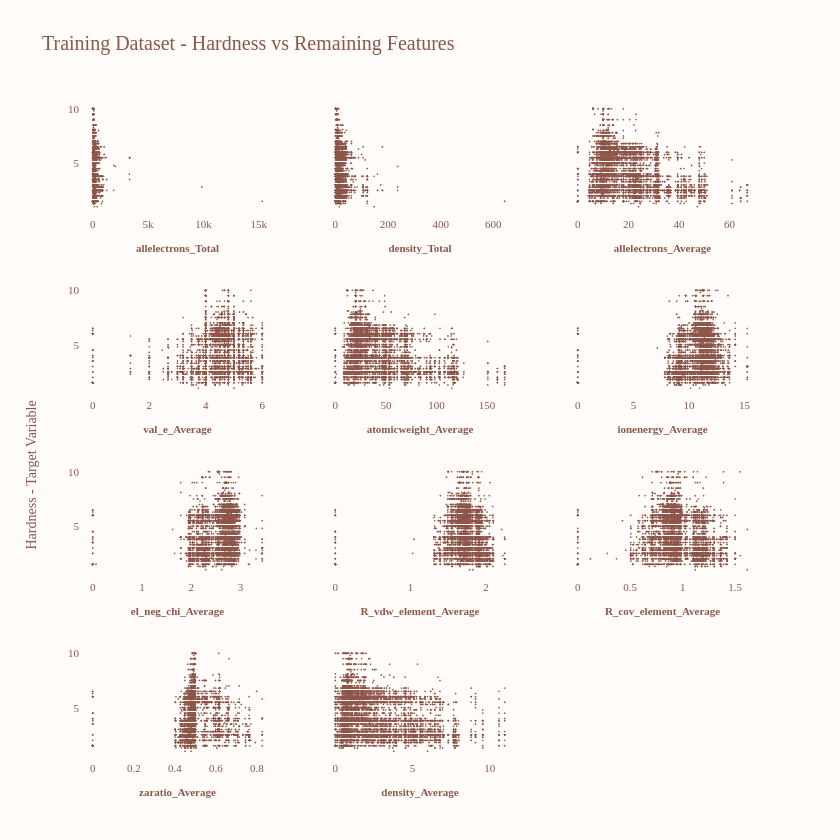

In [19]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Hardness - Target Variable",
    horizontal_spacing=0.07,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, features):
    fig.add_scatter(
        x=train[feature],
        y=train.Hardness,
        mode="markers",
        name=feature,
        row=row,
        col=col,
    )
    fig.update_xaxes(
        title_text=f"<b>{feature}</b>",
        row=row,
        col=col,
    )
    if not col == 1:
        fig.update_yaxes(showticklabels=False, row=row, col=col)

fig.update_layout(
    title="Training Dataset - Hardness vs Remaining Features",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
)
save_and_show_fig(fig, "scatter_plots")

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Probability Plots &amp; Example Transformations</span></b><a class="anchor" id="probability_plots_and_example_transformations"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This subsection focuses on the exploration of probability plots, which are a graphical technique used to determine if a variable adheres to a particular distribution, specifically the normal distribution in this case. <b>Probability plots display samples that follow a normal distribution along a straight diagonal line.</b> Some machine learning models make the assumption that variables follow a normal distribution. Consequently, the mentioned technique assists in determining the necessary transformations to improve the variable's alignment with that distribution. We will begin with examining the original values and observing the outcomes.
</p>

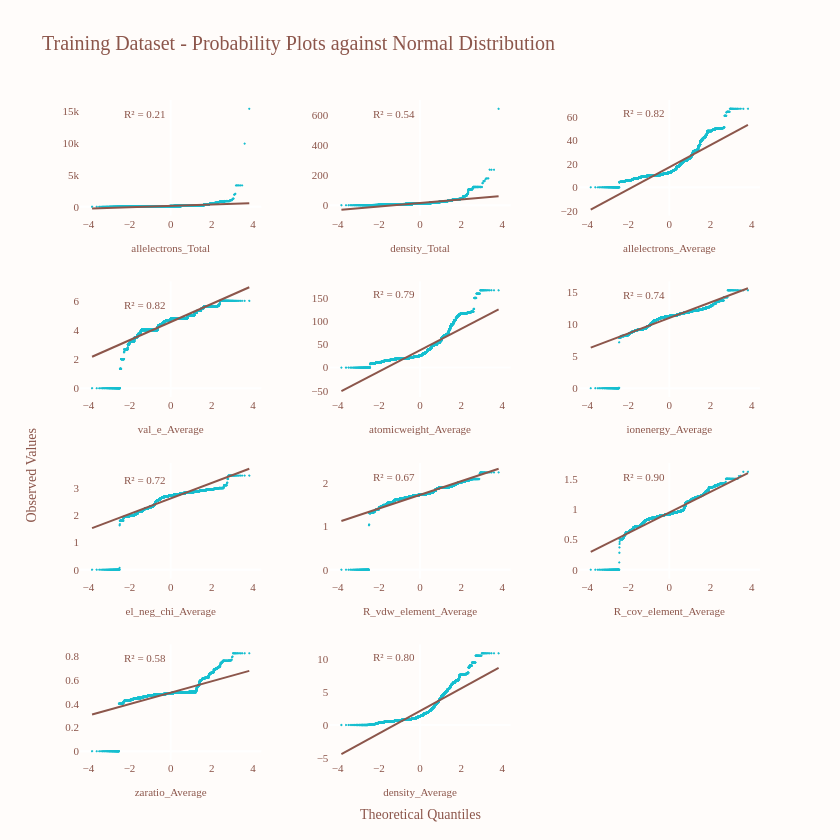

In [20]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Observed Values",
    x_title="Theoretical Quantiles",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, features):
    (osm, osr), (slope, intercept, R) = stats.probplot(train[feature].dropna(), rvalue=True)
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row, col=col, name=feature)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row, col=col)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.95,
        text=R2,
        showarrow=False,
        row=row,
        col=col,
        font_size=11,
    )
    fig.update_xaxes(
        title_text=f"{feature}",
        row=row,
        col=col,
    )

fig.update_layout(
    title="Training Dataset - Probability Plots against Normal Distribution",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
    line_color=COLOR_SCHEME[0],
)
save_and_show_fig(fig, "probability_plots")

Probability Plots against Normal Distribution

* Some variables fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line. However, there are same of features which have a poor fit. We can improve that through specific transformations. Mostly used transformations are log-level and square-root ones. These work fine with right-skewed data and help to reduce the impact of outliers. Another transformation is, for example, a reciprocal one, which is sometimes used when data is skewed, or there are obvious outliers. More sophisticated methods are Box-Cox transformation (requires strictly positive numbers) and Yeo-Johnson (variation of Box-Cox), which has no restrictions concerning numbers. We will check three of mentioned: log-level, square-root and Yeo-Johnson. For this case, we will utilise the <code>probplot</code> function from the <code>scipy</code> module to get R-squared coefficients as earlier.


In [21]:
r2_scores = pd.DataFrame(index=("Original", "YeoJohnson", "Log", "Sqrt"))

for feature in features:
    orig = train[feature].dropna()
    _, (*_, R_orig) = stats.probplot(orig, rvalue=True)
    _, (*_, R_yeojohn) = stats.probplot(stats.yeojohnson(orig)[0], rvalue=True)
    _, (*_, R_log) = stats.probplot(np.log1p(orig), rvalue=True)
    _, (*_, R_sqrt) = stats.probplot(np.sqrt(orig), rvalue=True)

    r2_scores[feature] = (
        R_orig * R_orig,
        R_yeojohn * R_yeojohn,
        R_log * R_log,
        R_sqrt * R_sqrt,
    )

r2_scores = r2_scores.transpose()
r2_scores["Winner"] = r2_scores.idxmax(axis=1)
get_pretty_frame(r2_scores)

,Original,YeoJohnson,Log,Sqrt,Winner
allelectrons_Total,0.215,0.919,0.876,0.770,YeoJohnson
density_Total,0.536,0.979,0.979,0.885,YeoJohnson
allelectrons_Average,0.817,0.921,0.908,0.903,YeoJohnson
val_e_Average,0.816,0.951,0.543,0.562,YeoJohnson
atomicweight_Average,0.795,0.917,0.891,0.896,YeoJohnson
ionenergy_Average,0.737,0.947,0.340,0.448,YeoJohnson
el_neg_chi_Average,0.718,0.926,0.503,0.455,YeoJohnson
R_vdw_element_Average,0.672,0.942,0.465,0.375,YeoJohnson
R_cov_element_Average,0.895,0.914,0.826,0.689,YeoJohnson
zaratio_Average,0.583,0.612,0.535,0.376,YeoJohnson


R-squared Scores within Some Transformations
    
    Well, as you can see <b>Yeo-Johnson's transformation wins in all cases and improves fit to the normal distribution pretty well</b> ($R^2$ scores almost in all cases are above $0.90$). However, there is a one feature where none of the transformations helps, i.e. <code>zaratio_Average</code>. Probably it's the effect of specific shape of this feature (looks like a half-normal distribution). Let's see how Yeo-Johnson transformation helps with specific feature, for example, the <code>density_Total</code> one.
</p>

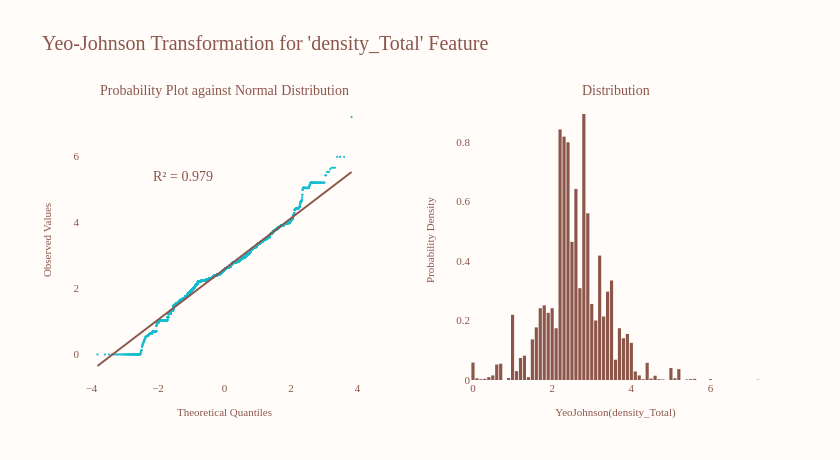

In [22]:
density_Total_transformed = stats.yeojohnson(train.density_Total.dropna())[0]
(osm, osr), (slope, intercept, R) = stats.probplot(density_Total_transformed, rvalue=True)
x_theory = np.array([osm[0], osm[-1]])
y_theory = intercept + slope * x_theory

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Probability Plot against Normal Distribution", "Distribution"],
    horizontal_spacing=0.15,
)

fig.add_scatter(x=osm, y=osr, mode="markers", row=1, col=1, name="YeoJohnson(density_Total)")
fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=1, col=1)
fig.add_annotation(
    x=-1.25,
    y=osr[-1] * 0.75,
    text=f"R\u00b2 = {R * R:.3f}",
    showarrow=False,
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Observed Values", row=1, col=1)
fig.update_xaxes(title_text="Theoretical Quantiles", row=1, col=1)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
    line_color=COLOR_SCHEME[0],
)

fig.add_histogram(
    x=density_Total_transformed,
    xbins=go.histogram.XBins(size=0.1),
    marker_color=COLOR_SCHEME[0],
    name="YeoJohnson(density_Total)",
    histnorm="probability density",
    row=1,
    col=2,
)
fig.update_yaxes(title_text="Probability Density", row=1, col=2)
fig.update_xaxes(title_text="YeoJohnson(density_Total)", row=1, col=2)

fig.update_layout(
    title="Yeo-Johnson Transformation for 'density_Total' Feature",
    showlegend=False,
    width=840,
    height=460,
    bargap=0.2,
)
fig.update_annotations(font_size=14)
save_and_show_fig(fig, "density_Total_after_transform")

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Features Importance</span></b><a class="anchor" id="features_importance"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will tackle the general problem of features' importance. Generally, sometimes not all variables are crucial during the training process, and only some are relevant for specific models. There are many methods, from selecting some top features based on the ANOVA test, mutual information, up to recursive feature selection with cross-validation. We can also select features from given models like random forest using the importance ratio. Generally, different methods may give different results. Moreover, it's good to include random variables in training data and measure their importance. <b>If some random numbers are more important than given features, it means that those variables are useless (may introduce a noise) from the problem perspective (but still can be useful in other tasks).</b> In this section, we will investigate decision process in a simple decision tree, and the we will focus on gradient boosting trees. We will see permutation tests, random variables, mutual information, one-way partial dependence plots (PDPs) and two-way PDPs.<br><br>
    <b>This section has a showcase character and all what can you see here may be slightly different depending on used machine learning algorithm or random seeds. Nevertheless, it will show us, in general, which features are more important and which are not.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Decision Process in Simple Decision Tree</span></b><a class="anchor" id="simple_decision_tree_and_its_decision_process"></a> [↑](#top)

In [23]:
X = train.drop("Hardness", axis=1)
y = train.Hardness

DefaultDecisionTreeRegressor = partial(
    DecisionTreeRegressor,
    criterion="absolute_error",  # Watch out on learning time complexity.
    random_state=42,
    max_depth=3,
)

tree = DefaultDecisionTreeRegressor().fit(X, y)

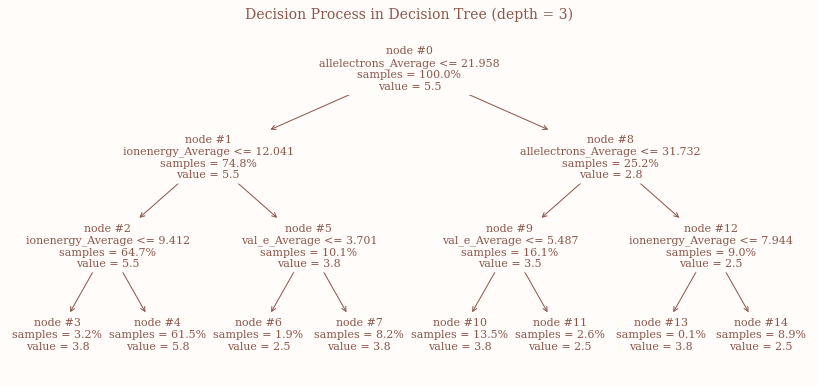

In [24]:
plt.figure(figsize=(11.5, 5.5), tight_layout=True)
plot_tree(
    decision_tree=tree,
    feature_names=tree.feature_names_in_.tolist(),
    filled=False,
    rounded=True,
    impurity=False,
    proportion=True,
    node_ids=True,
    ax=plt.gca(),
    fontsize=11,
)
plt.title("Decision Process in Decision Tree (depth = 3)")
plt.savefig("images/decision_process_in_tree")
plt.show()

In [25]:
for depth in range(2, 7):
    tree.set_params(max_depth=depth).fit(X, y)
    considered_features = tree.tree_.feature[tree.tree_.feature != -2]  # type: ignore # -2 means a leaf
    used_features = np.unique(considered_features)
    used_features = X.columns[used_features].to_list()
    print(CLR + f"Features at depth {depth}: {RED}{len(used_features):<5}", end="")
    tree_cv_results = -cross_val_score(
        estimator=tree,
        X=X,
        y=y,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_median_absolute_error",
        n_jobs=2,
    )
    mean, std = tree_cv_results.mean(), tree_cv_results.std()
    print(CLR + "MedAE:", RED + f"{mean:.2f} \u00b1 {std:.2f}")

Features at depth 2: 2    

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


MedAE: 0.66 ± 0.08
Features at depth 3: 3    MedAE: 0.50 ± 0.00
Features at depth 4: 8    MedAE: 0.50 ± 0.00
Features at depth 5: 10   MedAE: 0.50 ± 0.00
Features at depth 6: 11   MedAE: 0.50 ± 0.00


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Decision Process in Tree</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, we've got here a simple, default decision tree within a depth of $3$. I used such a depth to easily show you nodes. Subsequently, I performed cross-validation to assess how depth influences the outcome, and it turns out that we get the same output as the depth is equal to $3$ or more. So, three features are enough to get MedAE $= 0.5$. Is that decent? Probably not. Moreover, note that number of considered features at depth $4$ increases from $3$ to $8$, compared to depth $3$. 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Random Variables &amp; Permutation Test</span></b><a class="anchor" id="random_variables_permutation_test"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, we're going to start by introducing random variables to the dataset. Why? Well, when you introduce random variables to the dataset and train the model, you may check feature importances, for example, based on reduction in MAE criterion. <b>When a random variable contributes to the reduction of MAE more than the specific feature available in the dataset, it means that this feature is a noise indeed from the task perspective.</b>
</p>

In [26]:
DefaultLGBMRegressor = partial(
    LGBMRegressor,
    objective="regression_l1",
    random_state=42,
    verbose=-1,
)

In [27]:
np.random.seed(42)
seeds = np.random.randint(0, 19937, size=5)

X = train.drop("Hardness", axis=1)
y = train.Hardness

lgbm = DefaultLGBMRegressor()
importances = []

for seed in seeds:
    np.random.seed(seed)
    X["RANDOM_1"] = np.random.normal(size=len(X))
    X["RANDOM_2"] = np.random.normal(size=len(X))
    X["RANDOM_3"] = np.random.normal(size=len(X))
    X["RANDOM_4"] = np.random.normal(size=len(X))
    X["RANDOM_5"] = np.random.normal(size=len(X))

    lgbm.set_params(random_state=seed).fit(X, y)
    importances.append(unit_norm(lgbm.feature_importances_))

importances = (
    pd.DataFrame({"Feature": X.columns, "Importance": np.array(importances).mean(axis=0)})
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

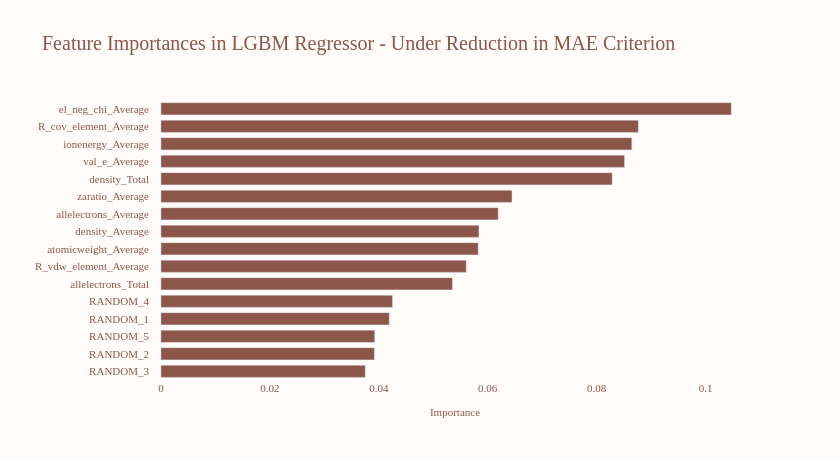

In [28]:
fig = px.bar(
    importances,
    x="Importance",
    y="Feature",
    height=460,
    width=840,
    title="Feature Importances in LGBM Regressor - Under Reduction in MAE Criterion<br>",
)
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_xaxes(range=(-0.002, 0.11))
fig.update_traces(width=0.7)
save_and_show_fig(fig, "importance_with_mae_reduction")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature Importances via Reduction in MAE</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here I used $5$ different seeds to gain more reliable results. <b>As we can see, in this specific situation, most of variables are more important than random ones.</b> However, some of them are at the randomness level. What is more, if we had defined only one random feature, it could turn out that we've been just lucky that it's essential or not. We have a more general recognition when we define several of them.
</p>

In [29]:
np.random.seed(42)
seeds = np.random.randint(0, 19937, size=5)

lgbm = DefaultLGBMRegressor()
permutation_medae = defaultdict(list)

for seed in seeds:
    np.random.seed(seed)
    X["RANDOM_1"] = np.random.normal(size=len(X))
    X["RANDOM_2"] = np.random.normal(size=len(X))
    X["RANDOM_3"] = np.random.normal(size=len(X))
    X["RANDOM_4"] = np.random.normal(size=len(X))
    X["RANDOM_5"] = np.random.normal(size=len(X))

    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    lgbm.set_params(random_state=seed)

    for k, (train_ids, valid_ids) in enumerate(kfold.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y[train_ids]  # type: ignore
        X_valid, y_valid = X.iloc[valid_ids], y[valid_ids]  # type: ignore

        lgbm.fit(X_train, y_train)
        medae = median_absolute_error(y_valid, lgbm.predict(X_valid))  # type: ignore

        for i, feature in enumerate(X_train.columns):
            X_shuffled = X_valid.copy()
            X_shuffled.iloc[:, i] = np.random.permutation(X_shuffled.iloc[:, i])
            medae_shuffled = median_absolute_error(y_valid, lgbm.predict(X_shuffled))  # type: ignore
            # I assume an increase in MedAE if the attribute is essential.
            permutation_medae[feature].append(((medae_shuffled - medae) / medae) * 100.0)

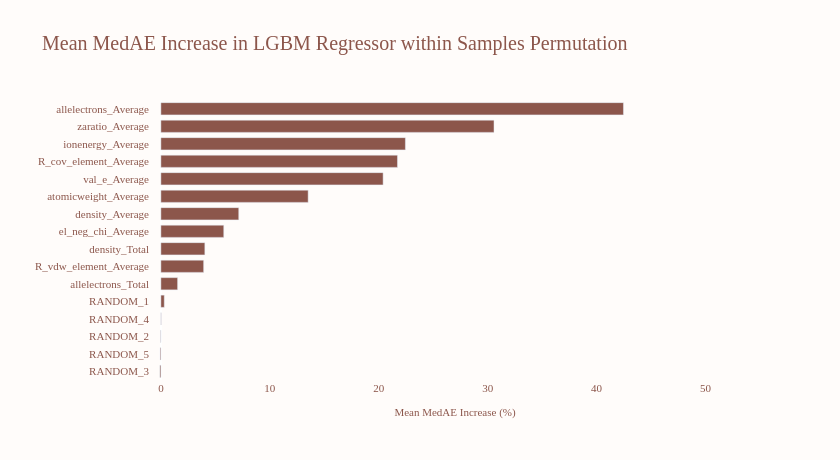

In [30]:
medae_increase = (
    pd.DataFrame(permutation_medae)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="Mean MedAE Increase (%)")
    .reset_index(names="Feature")
)

fig = px.bar(
    medae_increase,
    x="Mean MedAE Increase (%)",
    y="Feature",
    height=460,
    width=840,
    title="Mean MedAE Increase in LGBM Regressor within Samples Permutation<br>",
)
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_xaxes(range=(-1, 55))
fig.update_traces(width=0.7)
save_and_show_fig(fig, "importance_with_feature_permutation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Samples Permutation Test</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the code above, we explore how rearranging samples within a specific feature affects MedAE when evaluating the validation dataset. To ensure more reliable outcomes, this entire process is repeated with different random seeds. Importantly, throughout this entire process, we shuffle samples in the chosen feature of the validation subset and record results obtained from evaluating this modified dataset in a separate dictionary. If the variable is significant, we should observe worsened results in terms of MedAE. <b>As we can see, some features punish the model mostly. But it doesn't concern random variables.</b> For <code>density_Total</code>, <code>density_Average</code>, and <code>allelectrons_Total</code> variables the situation is similar to random features.<br><br>
    Everything I show here is only illustrative, and the aim is to gain a little intuition about available features. Different models can recognise various features as relevant ones. Moreover, when you set a certain depth or minimum number of samples in a leaf in the tested gradient boosting regressor, you probably get a slightly different outcome. 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Mutual Information</span></b><a class="anchor" id="mutual_information"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Let's check feature importance via the mutual information method. Generally, mutual information is a quantity that measures the relation between simultaneously sampled variables. In other words, it measures how much information about one variable is, on average, enclosed in the second variable. Intuitively, we can ask how much one variable tells us about the second one. <b>The theorem says that the mutual information between two variables is zero if and only if these are statistically independent.</b>
</p>

In [31]:
np.random.seed(42)
seeds = np.random.randint(0, 19937, size=5)

scaler = StandardScaler()
mutual_info = []

for seed in seeds:
    np.random.seed(seed)
    X["RANDOM_1"] = np.random.normal(size=len(X))
    X["RANDOM_2"] = np.random.normal(size=len(X))
    X["RANDOM_3"] = np.random.normal(size=len(X))
    X["RANDOM_4"] = np.random.normal(size=len(X))
    X["RANDOM_5"] = np.random.normal(size=len(X))

    # Choose of neighbors is subjective.
    mi = mutual_info_regression(X=scaler.fit_transform(X), y=y, n_neighbors=50, random_state=seed)
    mutual_info.append(mi)

mi_importances = (
    pd.DataFrame({"Feature": X.columns, "Mutual Information": np.array(mutual_info).mean(axis=0)})
    .sort_values(by="Mutual Information", ascending=False)
    .reset_index(drop=True)
)

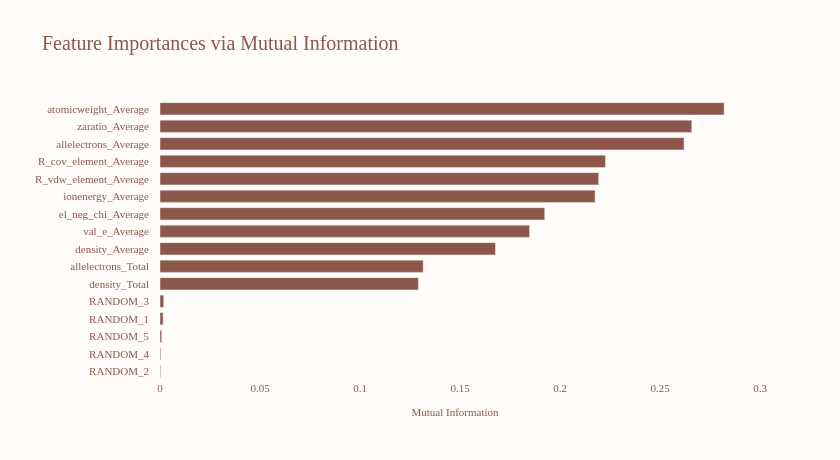

In [32]:
fig = px.bar(
    mi_importances,
    x="Mutual Information",
    y="Feature",
    height=460,
    width=840,
    title="Feature Importances via Mutual Information",
)
fig.update_yaxes(categoryorder="total ascending", title="")
fig.update_xaxes(range=(-0.005, 0.3))
fig.update_traces(width=0.7)
save_and_show_fig(fig, "mutual_information")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Mutual Information Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see, mutual information says that all features are more important than randome variables. Therefore, this is a slightly different outcome than in tests with random forest. Let's get to something more interesting, i.e. partial dependence plots.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.4</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Partial Dependence for Features of Interest</span></b><a class="anchor" id="partial_dependence_for_features_of_interest"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Generally, a partial dependence plot (PDP) is another tool for visualizing feature importance. However, this approach differs slightly from the earlier depicted. <b>Here, the partial dependence plot shows the relationship between the model outcome and a particular feature or a set of particular features.</b> In this case, the outcome (partial dependence) is an output of the <code>predict()</code> method. So, it's just a prediction for the <code>Hardness</code> variable. In other words, according to <code>scikit-learn</code> docs: <i>Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.</i> Let's have a look at how it works and how it looks.
</p>

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


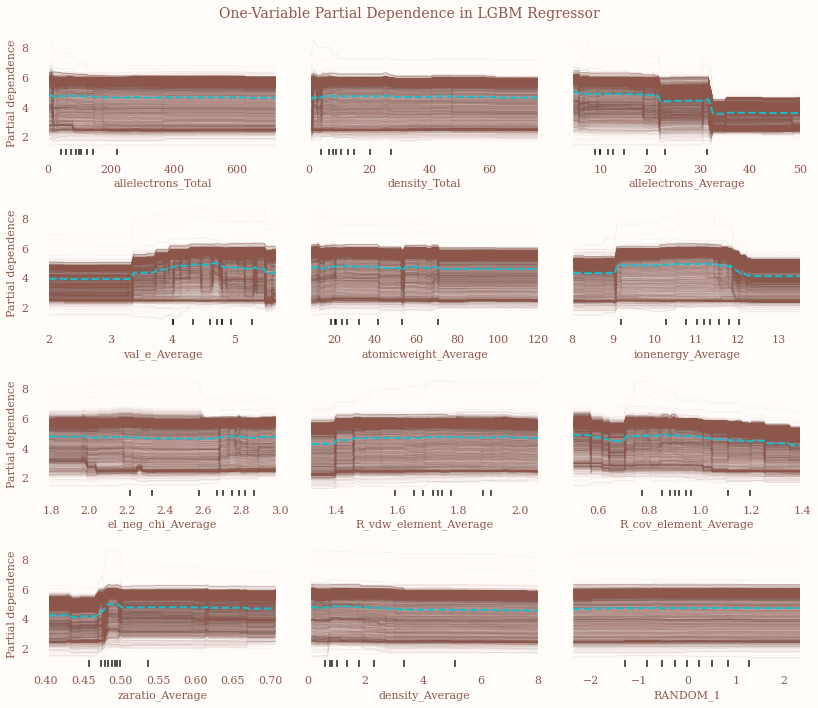

In [33]:
np.random.seed(42)

X = train.drop("Hardness", axis=1).assign(RANDOM_1=np.random.normal(size=len(train)))
y = train.Hardness

lgbm = DefaultLGBMRegressor().fit(X, y)

fig, axes = plt.subplots(4, 3, figsize=(11.5, 10), tight_layout=True, sharey=True)
plt.suptitle("One-Variable Partial Dependence in LGBM Regressor")
PartialDependenceDisplay.from_estimator(
    estimator=lgbm,  # type: ignore
    X=X,
    features=X.columns.tolist(),
    feature_names=X.columns.tolist(),
    response_method="auto",  # In regression, the response is `predict()` output.
    kind="both",  # PDP and ICE.
    percentiles=(0.01, 0.99),
    subsample=0.5,
    random_state=42,
    n_jobs=-1,
    ice_lines_kw={"color": COLOR_SCHEME[0], "linewidth": 0.2, "alpha": 0.1, "linestyle": "--"},
    pd_line_kw={"color": COLOR_SCHEME[2], "linewidth": 2.0},
    ax=axes.ravel(),  # type: ignore
)

for ax in axes.ravel():
    ax.get_legend().remove()
    if ax not in (axes[0, 0], axes[1, 0], axes[2, 0], axes[3, 0]):
        ax.set_ylabel("")

plt.savefig("images/one_way_partial_dependence")
plt.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Partial Dependence</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we have PDP visualizations all features of interest. I included one random variable to show you how looks a feature that does not drive any influence.This way, we can see how different features impact the model, whether it's a linear dependence or not. What is more, one needs to add something. <b>Actually, we've created PDP and individual conditional expectation (ICE) plots. ICE is similar to PDP, but here, the ICE plot shows the dependency of the prediction within a given feature for each sample (it means each black line corresponds to a specific sample).</b><br><br>
    Well, so what do we see here? I describe it using the <code>ionenergy_Average</code> feature of interest. Firstly, we need to remember that interactions between features are not included here. It means that we see predictions of the model (partial dependence) depending on only one feature. Concerning the <code>ionenergy_Average</code> variable, we can see that initially the output is constant as the feature grows, i.e. the dependence is constant in the range $(8, 9)$ of <code>ionenergy_Average</code>. On a higher cut-off, the <code>ionenergy_Average</code> starts to drive an influence on the model, i.e., in the range $~9.0$ the dependence is positive and (probably?) non-linear. Next, in the range $(9, 12.0)$ it's a constant again, and subsequently has a negative impact. <b>So there are narrow ranges of this feature where the outcome rapidly grows or drops.</b><br><br>
    Now let's have a look at random variable. The dependence is always constant here, which means that this feature doesn't introduce any information. Now let's have a look at PDP with two input features of interest. That will show us interactions.
</p>

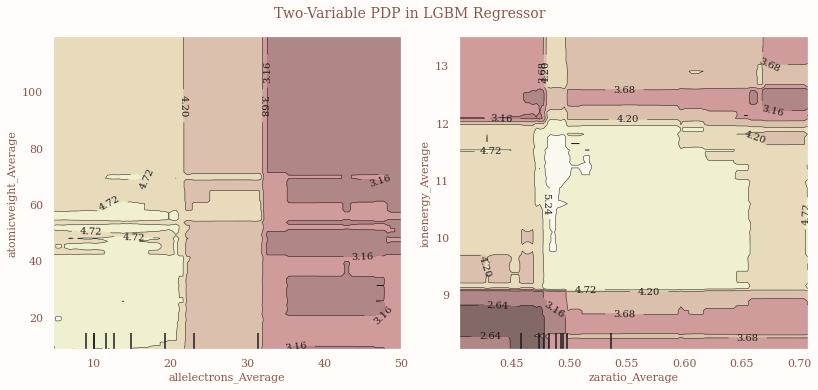

In [34]:
interaction_pair1 = ["allelectrons_Average", "atomicweight_Average"]
interaction_pair2 = ["zaratio_Average", "ionenergy_Average"]

X = train[np.union1d(interaction_pair1, interaction_pair2)]
y = train.Hardness
lgbm = DefaultLGBMRegressor().fit(X, y)  # type: ignore

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 5.5), tight_layout=True)
plt.suptitle("Two-Variable PDP in LGBM Regressor")
PartialDependenceDisplay.from_estimator(
    estimator=lgbm,  # type: ignore
    X=X,
    features=[interaction_pair1, interaction_pair2],
    feature_names=X.columns.to_list(),
    response_method="auto",  # In regression, the response is `predict()` output.
    percentiles=(0.01, 0.99),
    random_state=42,
    n_jobs=-1,
    contour_kw={"cmap": "pink"},
    ax=axes,  # type: ignore
)

plt.savefig("images/two_way_partial_dependence")
plt.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Interactions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The two-variable PDP above shows the dependence of the target variable on joint values of two pairs, i.e. (<code>allelectrons_Average</code>, <code>atomicweight_Average</code>) and (<code>zaratio_Average</code>, <code>ionenergy_Average</code>). Here, for example, we can see that if the <code>zaratio_Average</code> is greater than $0.5$, the main impact on prediction has <code>ionenergy_Average</code>, but when <code>zaratio_Average</code> is in the range $(0.45, 0.50)$, the situation is diversed.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Dimensionality Reduction</span></b><a class="anchor" id="dimensionality_reduction"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have several interesting dimensionality reduction algorithms, like t-SNE, PCA or LLE. For example the t-SNE method is a great reduction technique commonly used for visualizing complex and high-dimensional data in a lower-dimensional space. Moreover, it tries to preserve the original structure of data, so similar samples should be deployed close to each other in reduced dimensions. Using t-SNE we should provide scaled data, otherwise, certain dimensions can be dominated by features with larger scales or units. For the purpose of this notebook, we can test two techniques, i.e. PCA, Isomap and t-SNE.
</p>

In [35]:
X = train.drop("Hardness", axis=1)
y = train.Hardness

transformer = PowerTransformer(method="yeo-johnson", standardize=True)
X_rescaled = transformer.fit_transform(X)

pca_2d = PCA(n_components=2, random_state=42)
iso_2d = Isomap(n_components=2, n_neighbors=20, n_jobs=-1)
tsne_2d = TSNE(n_components=2, random_state=42, n_jobs=-1)

pca_2d_results = pd.DataFrame(pca_2d.fit_transform(X_rescaled), columns=("x1", "x2")).join(y)
iso_2d_results = pd.DataFrame(iso_2d.fit_transform(X_rescaled), columns=("x1", "x2")).join(y)
tsne_2d_results = pd.DataFrame(tsne_2d.fit_transform(X_rescaled), columns=("x1", "x2")).join(y)

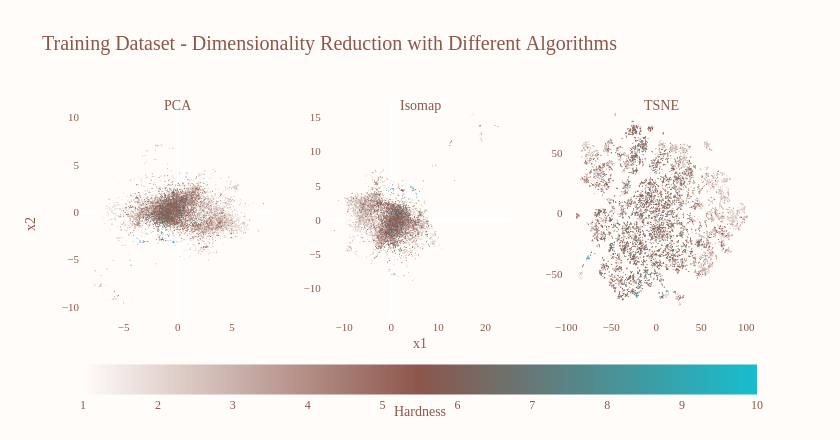

In [36]:
n_cols, n_projections = 3, 3
n_rows, axes = get_n_rows_and_axes(n_projections, n_cols)
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=("PCA", "Isomap", "TSNE"),
    x_title="x1",
    y_title="x2",
    # horizontal_spacing=0.1,
    vertical_spacing=0.1,
)

for (row, col), projection in zip(axes, (pca_2d_results, iso_2d_results, tsne_2d_results)):
    fig.add_scatter(
        x=projection.x1,
        y=projection.x2,
        mode="markers",
        marker=dict(size=1, color=projection.Hardness, coloraxis="coloraxis"),
        row=row,
        col=col,
        showlegend=False,
    )

fig.update_annotations(font_size=14, yshift=-15)
fig.update_coloraxes(
    colorbar=dict(
        title_text="Hardness",
        ticklabelposition="outside bottom",
        orientation="h",
        title_side="bottom",
        yanchor="bottom",
        xanchor="center",
        len=1.02,
        y=-0.5,
        x=0.5,
    ),
    colorscale=colormap,
)
fig.update_layout(
    title="Training Dataset - Dimensionality Reduction with Different Algorithms",
    width=840,
    height=440,
)
save_and_show_fig(fig, "projections_2d")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Dimensionality Reduction Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see, PCA and Isomap produce kind similar outcomes. On the other hand, t-SNE creates a pretty cool low-dimensional visual. Let's get one step further and use t-SNE to create a 3D projection.
</p>

In [37]:
tsne_3d = TSNE(n_components=3, random_state=42, n_jobs=-1)
tsne_3d_results = pd.DataFrame(tsne_3d.fit_transform(X_rescaled), columns=("x1", "x2", "x3")).join(y)

fig = px.scatter_3d(
    tsne_3d_results,
    x="x1",
    y="x2",
    z="x3",
    color="Hardness",
    color_continuous_scale=colormap,
    opacity=0.5,
    height=840,
    width=840,
    title="Training Dataset - 3D Projection with t-SNE<br>",
)
fig.update_traces(marker_size=2)
fig.update_coloraxes(colorbar=dict(ticklabelposition="outside bottom"))
fig.show()

Dimensionality Reduction with t-SNE


    So, here we see that t-SNE tried to separate samples with different Hardness value levels. For example, there is an area that is dominated by samples with low Hardness. Well, dimensionality reduction is a nice tool but in this specific problem samples seems to be difficult to separate them clearly.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">4</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Outliers Detection</span></b><a class="anchor" id="outliers_detection"></a> [↑](#top)


    Generally, there are several methods available in the scikit-learnlibrary if you ask for the outlier detector, such as SGDOneClassSVM, which is a linear model, LocalOutlierFactor, which is based on nearest neighbours, andIsolationForest based on bagging trees. We will focus on the LocalOutlierFactor, but I provide a code that you can easily modify to change a detector.
    Okay, so how do we assess whether removing outliers will probably work for the test dataset? Well, let's cross-validate it. The point is that we carry on typical cross-validation, but in addition to train the model on the training subset, we train it again on the "clean" training subset, where "clean" means a subset without outliers. Subsequently, we collect results obtained for validation subsets for two types of models. This trained on full training subset and that trained on clean subset. Suppose we observe a reduction in terms of a given metric for the validation subset in all folds. In that case, that's probably a good method of removing outliers. And here is a crucial point. We should observe a reduction in all folds. When we observe a reduction in some folds but not in others, we rather should not remove outliers because the test dataset can resemble that one fold when removing outliers came with lower model performance.


In [39]:
def remove_outliers(data, detector):
    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"'data' must be {pd.DataFrame!r} instance")

    result = detector.fit_predict(data)
    outlier_ids = pd.Series(result == -1, index=data.index, dtype=bool)
    data_ids = pd.Series(np.ones_like(data.index), index=data.index, dtype=bool)
    
    return data[~(outlier_ids & data_ids)]

Removing Outliers

    Since outlier detectors in scikit-learn predict $-1$ for the outlier sample, we create a mask and return the dataset without associated observations in the remove_outliers() function. Subsequently, below I create simple LGBM model which implements MAE loss pretty well compared to previously used random forests, and perform CV scheme I described earlier.


In [40]:
lgbm = DefaultLGBMRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
detector = make_pipeline(
    PowerTransformer(method="yeo-johnson", standardize=True),
    LocalOutlierFactor(),
)

hyperparameter = "localoutlierfactor__contamination"
hyperparameter_values = [None] + np.arange(0.01, 0.15, 0.01).tolist()
no_outliers_medae = {}

for k, (train_ids, valid_ids) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    lgbm.fit(X_train, y_train)
    default_medae = median_absolute_error(y_valid, lgbm.predict(X_valid))  # type:ignore

    for hp_value in hyperparameter_values:
        if hp_value is None:
            no_outliers_medae[f"0 - {k}"] = default_medae
            continue

        detector.set_params(**{hyperparameter: hp_value})
        X_no_outliers = remove_outliers(X_train, detector)
        y_no_outliers = y_train[X_no_outliers.index]

        lgbm.fit(X_no_outliers, y_no_outliers)
        clean_medae = median_absolute_error(y_valid, lgbm.predict(X_valid))  # type:ignore
        no_outliers_medae[f"{hp_value} - {k}"] = clean_medae

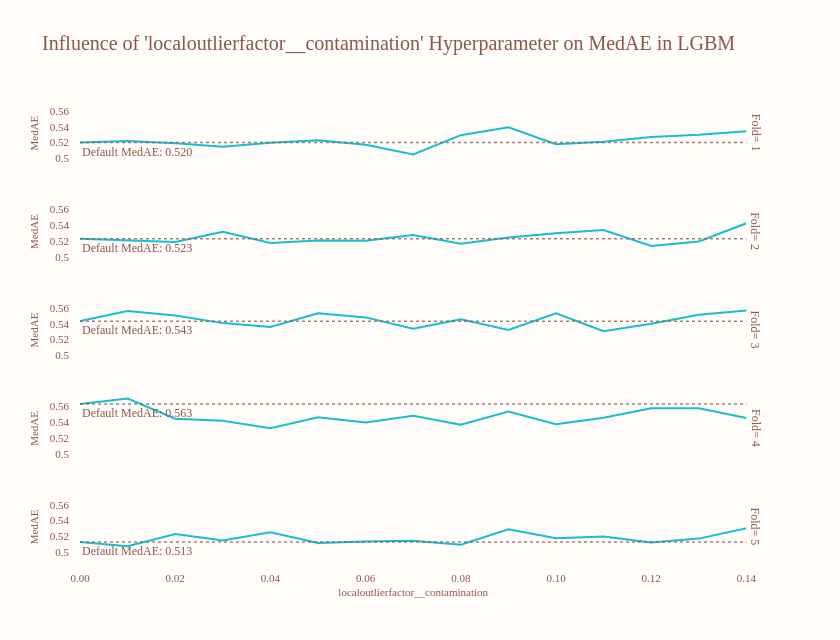

In [41]:
detector_medae = pd.DataFrame({"KEY": no_outliers_medae.keys(), "MedAE": no_outliers_medae.values()})
detector_medae[[hyperparameter, "Fold"]] = detector_medae.KEY.str.split("-", expand=True)
default_medae = detector_medae[detector_medae[hyperparameter].astype(float) == 0].MedAE

fig = px.line(
    detector_medae,
    x=hyperparameter,
    y="MedAE",
    facet_row="Fold",
    facet_row_spacing=0.07,
    color_discrete_sequence=COLOR_SCHEME[2:],
    height=640,
    width=840,
    title=f"Influence of '{hyperparameter}' Hyperparameter on MedAE in LGBM",
)
for fold, fold_default_medae in enumerate(default_medae):
    fig.add_hline(
        fold_default_medae,
        annotation_text=f"Default MedAE: {fold_default_medae:.3f}",
        annotation_position="bottom left",
        annotation_font_size=12,
        line_width=1.5,
        opacity=0.75,
        line_dash="dot",
        line_color=COLOR_SCHEME[0],
        row=len(default_medae) - fold,  # type:ignore
    )
fig.update_traces(line_width=2)
fig.update_layout(margin_pad=10)
fig.update_xaxes(tickformat=".2f", type="linear")
save_and_show_fig(fig, "outlier_detection")

Removing Outliers vs Performance

    Unfortunately, removing outliers didn't reduce MedAE in all folds for any of the contamination values in the LocalOutlierFactor detector. I also checked IsolationForest and SGDOneClassSVM with several hyperparameter combinations, but the result is similar. Of course, the whole process depends on model combination. Perhaps this method works for other regressor, rather than LGBM.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">5</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Modelling</span></b><a class="anchor" id="modelling"></a> [↑](#top)

Stacked Ensemble with H2O and optuna

In [42]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import optuna
from tqdm import tqdm
seed=42

#initilize H2O cluster
h2o.init()



Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpswfgvtwr
  JVM stdout: /tmp/tmpswfgvtwr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpswfgvtwr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_5ahfgm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.250 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [43]:
data_h2o=h2o.H2OFrame()

In [44]:
#load data
#H2O models can not take pandas dataframe so we need to convert from a Pandas Dataframe to H2O frame
train_data_h2o=h2o.H2OFrame(train)
test_data_h2o=h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [45]:
#H2O models can encode categorical feqtures automatically.They must be explicitly
#converted to factor(categorical)data.
categorical_cols=[col for col in train_data_h2o if col.dtype=='object']
for col in categorical_cols:
    train_data_h2o[col]=train_data_h2o[col].asfactor()
    test_data_h2o[col]=test_data_h2o[col].asfactor()

In [46]:
#split train data into train and validation using H2O functions
splits=train_data_h2o.split_frame(ratios=[0.8],seed=seed)
train1=splits[0]
val=splits[1]


In [48]:
#Unlike Scikit-Learn models which take as input the values of the 
#features and the target, H2O models take as input the names of the features and the target.
X = list(train1.columns)
y = 'Hardness'
X.remove(y)

In [49]:
print(X)

['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average']


Training Deep Neural Network(DNN) as base models

In [51]:
dnn_models=[]
def objective(trial):
    #params
    num_hidden_layers=trial.suggest_int('num_hidden_layers',1,10)
    hidden_layer_size=trial.suggest_int('hidden_layer_size',100,300,step=50)
    params={
        'hidden':[hidden_layer_size]*num_hidden_layers,
        'epochs': trial.suggest_int('epochs',5,100),
        'input_dropout_ratio':trial.suggest_float('input_dropout_ratio',0.1,0.3),
        'l1':trial.suggest_float('l1',1e-5,1e-1,log=True),
        'l2':trial.suggest_float('l2',1e-5,1e-1,log=True),
        'activation':trial.suggest_categorical('activation',["maxoutwithdropout", "tanhwithdropout", "tanh", "rectifierwithdropout", "rectifier", "maxout"])
    }
    
    if params['activation'] in ['RectifierWithDropout',"TanhWithDropout","MaxoutWithDropout"]:
        hidden_dropout_rtio=trial.suggest_float('hidden_dropout_ratio',0.1,1.0)
        params['hidden_dropout_ratios']=[hidden_dropout_rtio]*num_hidden_layers
    #Train model
    
    model=H2ODeepLearningEstimator(**params,
                                   standardize=True,
                                   categorical_encoding='auto',
                                   nfolds=5,
                                   keep_cross_validation_predictions=True,
                                   seed=seed
                                  )
    model.train(x=X,y=y,training_frame=train1)
    
    dnn_models.append(model)
    
    #CV score
    cv_metrics_df=model.cross_validation_metrics_summary().as_data_frame()
    cv_rmse_index=cv_metrics_df[cv_metrics_df['']=='rmse'].index
    cv_rmse=cv_metrics_df['mean'].iloc[cv_rmse_index]
    return cv_rmse

study= optuna.create_study(direction='minimize')
#study.optimize(objective,n_trials=20)

[I 2023-12-24 18:54:50,734] A new study created in memory with name: no-name-e309d05c-238a-400e-81ba-e2e2401c3cd5


deeplearning Model Build progress: |█████████████████████████████████████████████

/opt/conda/lib/python3.10/site-packages/optuna/study/_tell.py:66: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/conda/lib/python3.10/site-packages/optuna/study/_tell.py:70: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/conda/lib/python3.10/site-packages/optuna/study/_tell.py:168: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

[I 2023-12-24 19:38:39,852] Trial 0 finished with value: 1.3353298 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 200, 'epochs': 97, 'input_dropout_ratio': 0.24686732330492905, 'l1': 0.014779547290358368, 'l2': 0.0002887935667370728, 'activation': 'maxout'}. Best is trial 0 with value: 1.3353298.


| (done) 100%
deeplearning Model Build progress: |████████████████████████████████████████████

[I 2023-12-24 19:45:33,648] Trial 1 finished with value: 1.3503909 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size': 300, 'epochs': 40, 'input_dropout_ratio': 0.29464261968577804, 'l1': 0.007822940721884717, 'l2': 6.563155398901343e-05, 'activation': 'rectifier'}. Best is trial 0 with value: 1.3353298.


█| (done) 100%
deeplearning Model Build progress: |████████████████████████████████████████████

[I 2023-12-24 19:49:10,859] Trial 2 finished with value: 1.388254 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 100, 'epochs': 21, 'input_dropout_ratio': 0.2008268113538622, 'l1': 6.061843136301158e-05, 'l2': 0.08950724090355484, 'activation': 'maxoutwithdropout', 'hidden_dropout_ratio': 0.6722819886047761}. Best is trial 0 with value: 1.3353298.


█| (done) 100%
deeplearning Model Build progress: |████████████████████████████████████████████

[I 2023-12-24 20:01:30,954] Trial 3 finished with value: 1.330363 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size': 250, 'epochs': 86, 'input_dropout_ratio': 0.2797371490356676, 'l1': 0.003598622313165923, 'l2': 1.2528727163625337e-05, 'activation': 'rectifier'}. Best is trial 3 with value: 1.330363.


█| (done) 100%
deeplearning Model Build progress: |████████████████████████████████████████████

[I 2023-12-24 20:07:28,329] Trial 4 finished with value: 1.3284901 and parameters: {'num_hidden_layers': 6, 'hidden_layer_size': 200, 'epochs': 40, 'input_dropout_ratio': 0.1717720246351607, 'l1': 0.0021484972652591676, 'l2': 7.257528387520577e-05, 'activation': 'rectifier'}. Best is trial 4 with value: 1.3284901.


█| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████

[I 2023-12-24 20:16:28,458] Trial 5 finished with value: 1.4762943 and parameters: {'num_hidden_layers': 7, 'hidden_layer_size': 300, 'epochs': 11, 'input_dropout_ratio': 0.27721346011925885, 'l1': 5.493848491631135e-05, 'l2': 1.0699798211836454e-05, 'activation': 'rectifierwithdropout'}. Best is trial 4 with value: 1.3284901.


| (done) 100%
deeplearning Model Build progress: |████████████████████████████████████████████

[I 2023-12-24 20:18:10,070] Trial 6 finished with value: 1.3262926 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 200, 'epochs': 53, 'input_dropout_ratio': 0.16809388844421128, 'l1': 0.0003011052523849897, 'l2': 0.0014233983073090567, 'activation': 'maxout'}. Best is trial 6 with value: 1.3262926.
[W 2023-12-24 20:18:10,111] Trial 7 failed with parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 300, 'epochs': 67, 'input_dropout_ratio': 0.2522854076483675, 'l1': 0.002913477034802366, 'l2': 0.00018830864258370593, 'activation': 'tanh', 'hidden_dropout_ratio': 0.673226986249719} because of the following error: H2OResponseError(<h2o.schemas.error.H2OModelBuilderErrorV3 object at 0x7bc3fcc2fbe0>).
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_47/270263878.py", line 27, in objective
    model.train(x=X,y=y,training_frame=train

█| (done) 100%


H2OResponseError: ModelBuilderErrorV3  (water.exceptions.H2OModelBuilderIllegalArgumentException):
    timestamp = 1703449090081
    error_url = '/3/ModelBuilders/deeplearning'
    msg = "Illegal argument(s) for DeepLearning model: DeepLearning_model_python_1703443922009_9.  Details: ERRR on field: _hidden_dropout_ratios: Cannot specify hidden_dropout_ratios with a non-dropout activation function. Use 'RectifierWithDropout', 'TanhWithDropout', etc."
    dev_msg = "Illegal argument(s) for DeepLearning model: DeepLearning_model_python_1703443922009_9.  Details: ERRR on field: _hidden_dropout_ratios: Cannot specify hidden_dropout_ratios with a non-dropout activation function. Use 'RectifierWithDropout', 'TanhWithDropout', etc."
    http_status = 412
    values = {'messages': [{'_log_level': 5, '_field_name': '_fold_column', '_message': 'Fold column is ignored when nfolds > 1.'}, {'_log_level': 5, '_field_name': '_tweedie_power', '_message': 'Only for Tweedie Distribution.'}, {'_log_level': 5, '_field_name': '_tweedie_power', '_message': 'Tweedie power is only used for Tweedie distribution.'}, {'_log_level': 5, '_field_name': '_quantile_alpha', '_message': 'Quantile (alpha) is only used for Quantile regression.'}, {'_log_level': 5, '_field_name': '_max_after_balance_size', '_message': 'Balance classes is false, hide max_after_balance_size'}, {'_log_level': 5, '_field_name': '_balance_classes', '_message': 'Balance classes is only applicable to classification problems.'}, {'_log_level': 5, '_field_name': '_class_sampling_factors', '_message': 'Class sampling factors is only applicable to classification problems.'}, {'_log_level': 5, '_field_name': '_max_after_balance_size', '_message': 'Max after balance size is only applicable to classification problems.'}, {'_log_level': 5, '_field_name': '_max_confusion_matrix_size', '_message': 'Max confusion matrix size is only applicable to classification problems.'}, {'_log_level': 5, '_field_name': '_max_confusion_matrix_size', '_message': 'Only for multi-class classification problems.'}, {'_log_level': 5, '_field_name': '_max_after_balance_size', '_message': 'Only used with balanced classes'}, {'_log_level': 5, '_field_name': '_class_sampling_factors', '_message': 'Class sampling factors is only applicable if balancing classes.'}, {'_log_level': 5, '_field_name': '_score_validation_samples', '_message': 'score_validation_samples requires a validation frame.'}, {'_log_level': 5, '_field_name': '_classification_stop', '_message': 'classification_stop is used only with classification.'}, {'_log_level': 5, '_field_name': '_score_validation_sampling', '_message': 'score_validation_sampling requires classification and a validation frame.'}, {'_log_level': 5, '_field_name': '_hidden_dropout_ratios', '_message': 'hidden_dropout_ratios requires a dropout activation function.'}, {'_log_level': 1, '_field_name': '_hidden_dropout_ratios', '_message': "Cannot specify hidden_dropout_ratios with a non-dropout activation function. Use 'RectifierWithDropout', 'TanhWithDropout', etc."}, {'_log_level': 5, '_field_name': '_replicate_training_data', '_message': 'replicate_training_data is only valid with cloud size greater than 1.'}, {'_log_level': 5, '_field_name': '_overwrite_with_best_model', '_message': 'overwrite_with_best_model is unsupported in combination with n-fold cross-validation.'}, {'_log_level': 5, '_field_name': '_rate', '_message': 'rate is not used with adaptive_rate.'}, {'_log_level': 5, '_field_name': '_rate_annealing', '_message': 'rate_annealing is not used with adaptive_rate.'}, {'_log_level': 5, '_field_name': '_rate_decay', '_message': 'rate_decay is not used with adaptive_rate.'}, {'_log_level': 5, '_field_name': '_momentum_start', '_message': 'momentum_start is not used with adaptive_rate.'}, {'_log_level': 5, '_field_name': '_momentum_ramp', '_message': 'momentum_ramp is not used with adaptive_rate.'}, {'_log_level': 5, '_field_name': '_momentum_stable', '_message': 'momentum_stable is not used with adaptive_rate.'}, {'_log_level': 5, '_field_name': '_initial_weight_scale', '_message': 'initial_weight_scale is not used if initial_weight_distribution == UniformAdaptive.'}, {'_log_level': 5, '_field_name': '_elastic_averaging_moving_rate', '_message': 'Elastic averaging is required for this parameter.'}, {'_log_level': 5, '_field_name': '_elastic_averaging_regularization', '_message': 'Elastic averaging is required for this parameter.'}], 'algo': 'DeepLearning', 'parameters': {'_train': {'name': 'py_2_sid_944e', 'type': 'Key'}, '_valid': None, '_nfolds': 5, '_keep_cross_validation_models': True, '_keep_cross_validation_predictions': True, '_keep_cross_validation_predictions_precision': -1, '_keep_cross_validation_fold_assignment': False, '_parallelize_cross_validation': True, '_auto_rebalance': True, '_preprocessors': None, '_seed': 42, '_fold_assignment': 'AUTO', '_categorical_encoding': 'AUTO', '_max_categorical_levels': 10, '_distribution': 'AUTO', '_tweedie_power': 1.5, '_quantile_alpha': 0.5, '_huber_alpha': 0.9, '_ignored_columns': None, '_ignore_const_cols': True, '_weights_column': None, '_offset_column': None, '_fold_column': None, '_treatment_column': None, '_check_constant_response': True, '_is_cv_model': False, '_cv_fold': -1, '_score_each_iteration': False, '_max_runtime_secs': 0.0, '_main_model_time_budget_factor': 0.0, '_stopping_rounds': 5, '_stopping_metric': 'AUTO', '_stopping_tolerance': 0.0, '_response_column': 'Hardness', '_balance_classes': False, '_max_after_balance_size': 5.0, '_class_sampling_factors': None, '_max_confusion_matrix_size': 20, '_checkpoint': None, '_pretrained_autoencoder': None, '_custom_metric_func': None, '_custom_distribution_func': None, '_export_checkpoints_dir': None, '_gainslift_bins': -1, '_auc_type': 'AUTO', '_auuc_type': 'AUTO', '_auuc_nbins': -1, '_overwrite_with_best_model': True, '_autoencoder': False, '_use_all_factor_levels': True, '_standardize': True, '_activation': 'Tanh', '_hidden': [300], '_epochs': 67.0, '_train_samples_per_iteration': -2, '_target_ratio_comm_to_comp': 0.05, '_adaptive_rate': True, '_rho': 0.99, '_epsilon': 1e-08, '_rate': 0.005, '_rate_annealing': 1e-06, '_rate_decay': 1.0, '_momentum_start': 0.0, '_momentum_ramp': 1000000.0, '_momentum_stable': 0.0, '_nesterov_accelerated_gradient': True, '_input_dropout_ratio': 0.2522854076483675, '_hidden_dropout_ratios': [0.673226986249719], '_l1': 0.002913477034802366, '_l2': 0.00018830864258370593, '_max_w2': 3.4028235e+38, '_initial_weight_distribution': 'UniformAdaptive', '_initial_weight_scale': 1.0, '_initial_weights': None, '_initial_biases': None, '_loss': 'Automatic', '_score_interval': 5.0, '_score_training_samples': 10000, '_score_validation_samples': 0, '_score_duty_cycle': 0.1, '_classification_stop': 0.0, '_regression_stop': 1e-06, '_quiet_mode': False, '_score_validation_sampling': 'Uniform', '_diagnostics': True, '_variable_importances': True, '_fast_mode': True, '_force_load_balance': True, '_replicate_training_data': True, '_single_node_mode': False, '_shuffle_training_data': False, '_missing_values_handling': 'MeanImputation', '_sparse': False, '_col_major': False, '_average_activation': 0.0, '_sparsity_beta': 0.0, '_max_categorical_features': 2147483647, '_reproducible': False, '_export_weights_and_biases': False, '_elastic_averaging': False, '_elastic_averaging_moving_rate': 0.9, '_elastic_averaging_regularization': 0.001, '_mini_batch_size': 1}, 'error_count': 2}
    exception_msg = "Illegal argument(s) for DeepLearning model: DeepLearning_model_python_1703443922009_9.  Details: ERRR on field: _hidden_dropout_ratios: Cannot specify hidden_dropout_ratios with a non-dropout activation function. Use 'RectifierWithDropout', 'TanhWithDropout', etc."
    stacktrace = ["water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DeepLearning model: DeepLearning_model_python_1703443922009_9.  Details: ERRR on field: _hidden_dropout_ratios: Cannot specify hidden_dropout_ratios with a non-dropout activation function. Use 'RectifierWithDropout', 'TanhWithDropout', etc.\n", '    water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:19)', '    hex.ModelBuilder.trainModelOnH2ONode(ModelBuilder.java:340)', '    water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:51)', '    water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:16)', '    water.api.RequestServer.serve(RequestServer.java:472)', '    water.api.RequestServer.doGeneric(RequestServer.java:303)', '    water.api.RequestServer.doPost(RequestServer.java:227)', '    javax.servlet.http.HttpServlet.service(HttpServlet.java:707)', '    javax.servlet.http.HttpServlet.service(HttpServlet.java:790)', '    org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:799)', '    org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:554)', '    org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:233)', '    org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1440)', '    org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:188)', '    org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:505)', '    org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:186)', '    org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1355)', '    org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:141)', '    org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:146)', '    org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:127)', '    water.webserver.jetty9.Jetty9ServerAdapter$LoginHandler.handle(Jetty9ServerAdapter.java:130)', '    org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:146)', '    org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:127)', '    org.eclipse.jetty.server.Server.handle(Server.java:516)', '    org.eclipse.jetty.server.HttpChannel.lambda$handle$1(HttpChannel.java:487)', '    org.eclipse.jetty.server.HttpChannel.dispatch(HttpChannel.java:732)', '    org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:479)', '    org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:277)', '    org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:311)', '    org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:105)', '    org.eclipse.jetty.io.ChannelEndPoint$1.run(ChannelEndPoint.java:104)', '    org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:338)', '    org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:315)', '    org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:173)', '    org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:131)', '    org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:409)', '    org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:883)', '    org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:1034)', '    java.base/java.lang.Thread.run(Thread.java:829)']
    parameters = {'__meta': {'schema_version': 3, 'schema_name': 'DeepLearningParametersV3', 'schema_type': 'DeepLearningParameters'}, 'model_id': None, 'training_frame': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_2_sid_944e', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_2_sid_944e'}, 'validation_frame': None, 'nfolds': 5, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': True, 'keep_cross_validation_fold_assignment': False, 'parallelize_cross_validation': True, 'distribution': 'AUTO', 'tweedie_power': 1.5, 'quantile_alpha': 0.5, 'huber_alpha': 0.9, 'response_column': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'Hardness', 'is_member_of_frames': None}, 'weights_column': None, 'offset_column': None, 'fold_column': None, 'fold_assignment': 'AUTO', 'categorical_encoding': 'AUTO', 'max_categorical_levels': 10, 'ignored_columns': None, 'ignore_const_cols': True, 'score_each_iteration': False, 'checkpoint': None, 'stopping_rounds': 5, 'max_runtime_secs': 0.0, 'stopping_metric': 'AUTO', 'stopping_tolerance': 0.0, 'gainslift_bins': -1, 'custom_metric_func': None, 'custom_distribution_func': None, 'export_checkpoints_dir': None, 'auc_type': 'AUTO', 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'activation': 'Tanh', 'hidden': [300], 'epochs': 67.0, 'train_samples_per_iteration': -2, 'target_ratio_comm_to_comp': 0.05, 'seed': 42, 'adaptive_rate': True, 'rho': 0.99, 'epsilon': 1e-08, 'rate': 0.005, 'rate_annealing': 1e-06, 'rate_decay': 1.0, 'momentum_start': 0.0, 'momentum_ramp': 1000000.0, 'momentum_stable': 0.0, 'nesterov_accelerated_gradient': True, 'input_dropout_ratio': 0.2522854076483675, 'hidden_dropout_ratios': [0.673226986249719], 'l1': 0.002913477034802366, 'l2': 0.00018830864258370593, 'max_w2': 3.4028235e+38, 'initial_weight_distribution': 'UniformAdaptive', 'initial_weight_scale': 1.0, 'initial_weights': None, 'initial_biases': None, 'loss': 'Automatic', 'score_interval': 5.0, 'score_training_samples': 10000, 'score_validation_samples': 0, 'score_duty_cycle': 0.1, 'classification_stop': 0.0, 'regression_stop': 1e-06, 'quiet_mode': False, 'score_validation_sampling': 'Uniform', 'overwrite_with_best_model': True, 'autoencoder': False, 'use_all_factor_levels': True, 'standardize': True, 'diagnostics': True, 'variable_importances': True, 'fast_mode': True, 'force_load_balance': True, 'replicate_training_data': True, 'single_node_mode': False, 'shuffle_training_data': False, 'missing_values_handling': 'MeanImputation', 'sparse': False, 'col_major': False, 'average_activation': 0.0, 'sparsity_beta': 0.0, 'max_categorical_features': 2147483647, 'reproducible': False, 'export_weights_and_biases': False, 'mini_batch_size': 1, 'elastic_averaging': False, 'elastic_averaging_moving_rate': 0.9, 'elastic_averaging_regularization': 0.001, 'pretrained_autoencoder': None}
    messages = [{'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'fold_column', 'message': 'Fold column is ignored when nfolds > 1.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'tweedie_power', 'message': 'Only for Tweedie Distribution.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'tweedie_power', 'message': 'Tweedie power is only used for Tweedie distribution.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'quantile_alpha', 'message': 'Quantile (alpha) is only used for Quantile regression.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_after_balance_size', 'message': 'Balance classes is false, hide max_after_balance_size'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'balance_classes', 'message': 'Balance classes is only applicable to classification problems.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'class_sampling_factors', 'message': 'Class sampling factors is only applicable to classification problems.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_after_balance_size', 'message': 'Max after balance size is only applicable to classification problems.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_confusion_matrix_size', 'message': 'Max confusion matrix size is only applicable to classification problems.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_confusion_matrix_size', 'message': 'Only for multi-class classification problems.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_after_balance_size', 'message': 'Only used with balanced classes'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'class_sampling_factors', 'message': 'Class sampling factors is only applicable if balancing classes.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'score_validation_samples', 'message': 'score_validation_samples requires a validation frame.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'classification_stop', 'message': 'classification_stop is used only with classification.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'score_validation_sampling', 'message': 'score_validation_sampling requires classification and a validation frame.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'hidden_dropout_ratios', 'message': 'hidden_dropout_ratios requires a dropout activation function.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'hidden_dropout_ratios', 'message': "Cannot specify hidden_dropout_ratios with a non-dropout activation function. Use 'RectifierWithDropout', 'TanhWithDropout', etc."}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'replicate_training_data', 'message': 'replicate_training_data is only valid with cloud size greater than 1.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'overwrite_with_best_model', 'message': 'overwrite_with_best_model is unsupported in combination with n-fold cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'rate', 'message': 'rate is not used with adaptive_rate.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'rate_annealing', 'message': 'rate_annealing is not used with adaptive_rate.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'rate_decay', 'message': 'rate_decay is not used with adaptive_rate.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'momentum_start', 'message': 'momentum_start is not used with adaptive_rate.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'momentum_ramp', 'message': 'momentum_ramp is not used with adaptive_rate.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'momentum_stable', 'message': 'momentum_stable is not used with adaptive_rate.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'initial_weight_scale', 'message': 'initial_weight_scale is not used if initial_weight_distribution == UniformAdaptive.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'elastic_averaging_moving_rate', 'message': 'Elastic averaging is required for this parameter.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'elastic_averaging_regularization', 'message': 'Elastic averaging is required for this parameter.'}]
    error_count = 2


## Training XGBoost and LightGBM base models

In [ ]:
xgboost_lightgbm_models=[]
def objective(trial):
    
    params={
        'ntrees':trial.suggest_int('ntrees',50,5000),
        'max_depth':trial.suggest_int('max_depth',1,9),
        'min_rows':trial.suggest_int('min_rows',1,5),
        'sample_rate':trial.suggest_float('sample_rate',0.8,1.0),
        'col_sample_rate':trial.suggest_float('col_sample_rate',0.2,1.0),
        'col_sample_rate_per_tree':trial.suggest_float('col_sample_rate_per_tree',0.5,1.0)
    }
    
    grow_policy=trial.suggest_categorical('grow_policy',['depthwise','lossguide'])
    
    #add lightgbm specific params
    if grow_policy=='lossguide':
        tree_method='hist'
        params['max_bins']=trial.suggest_int('max_bind',20,256)
        params['max_leaves']=trial.suggest_int('max_leaves',31,1024)
    
    #add xgboost specific params
    else:
        tree_method='auto'
        params['booster']=trial.suggest_categorical('booster',['gbtree','gblinear','dart'])
        params['reg_alpha']=trial.suggest_float('reg_alpha',0.001,1)
        params['reg_lambda']=trial.suggest_float('reg_lambda',0.001,1)
        params['min_split_improvement']=trial.suggest_float('min_split_improvement',1e-10,1e-3,log=True)
    
    params['grow_policy']=grow_policy
    params['tree_method']=tree_method
    
    #train model
    model=H2OXGBoostEstimator(**params,
                              learn_rate=0.1,
                              categorical_encoding='auto',
                              nfolds=5,
                              keep_cross_validation_predictions=True,
                              seed=seed
                             )
    model.train(x=X,y=y,training_frame=train1)
    
    #store models
    xgboost_lightgbm_models.append(model)
    
    #CV
    
    cv_metrics_df=model.cross_validation_metrics_summary().as_data_frame()
    cv_rmse_index=cv_metrics_df[cv_metrics_df['']=='rmse'].index
    cv_rmse=cv_metrics_df['mean'].iloc[cv_rmse_index]
    return cv_rmse

study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)

    

[I 2023-12-24 20:32:18,769] A new study created in memory with name: no-name-2f48768b-abb4-48bf-bd81-87b37a839964


xgboost Model Build progress: |██████████████████████████████████████████████████

/opt/conda/lib/python3.10/site-packages/optuna/study/_tell.py:66: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/conda/lib/python3.10/site-packages/optuna/study/_tell.py:70: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/conda/lib/python3.10/site-packages/optuna/study/_tell.py:168: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

[I 2023-12-24 20:32:56,414] Trial 0 finished with value: 1.5319637 and parameters: {'ntrees': 1251, 'max_depth': 4, 'min_rows': 2, 'sample_rate': 0.9637578839047303, 'col_sample_rate': 0.6334982318850171, 'col_sample_rate_per_tree': 0.9357209939686107, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'reg_alpha': 0.3741673039997142, 'reg_lambda': 0.7068561813577

| (done) 100%
xgboost Model Build progress: |█████████████████████████████████████████████████

[I 2023-12-24 20:36:36,178] Trial 1 finished with value: 1.2893788 and parameters: {'ntrees': 1402, 'max_depth': 9, 'min_rows': 3, 'sample_rate': 0.9037464411535033, 'col_sample_rate': 0.6973958068061137, 'col_sample_rate_per_tree': 0.775755519630788, 'grow_policy': 'lossguide', 'max_bind': 121, 'max_leaves': 533}. Best is trial 1 with value: 1.2893788.


█| (done) 100%
xgboost Model Build progress: |█████████████████████████████████████████████████

[I 2023-12-24 20:38:51,892] Trial 2 finished with value: 1.2753793 and parameters: {'ntrees': 2511, 'max_depth': 9, 'min_rows': 2, 'sample_rate': 0.9274075690994645, 'col_sample_rate': 0.6683268044200623, 'col_sample_rate_per_tree': 0.8092400006898273, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'reg_alpha': 0.6420495553927106, 'reg_lambda': 0.8034791043953443, 'min_split_improvement': 3.249278154493401e-08}. Best is trial 2 with value: 1.2753793.


█| (done) 100%
xgboost Model Build progress: |█████████████████████████████████████████████████

[I 2023-12-24 20:42:19,790] Trial 3 finished with value: 1.3029974 and parameters: {'ntrees': 2126, 'max_depth': 8, 'min_rows': 4, 'sample_rate': 0.982309418570999, 'col_sample_rate': 0.421205722210316, 'col_sample_rate_per_tree': 0.8193313522915588, 'grow_policy': 'lossguide', 'max_bind': 48, 'max_leaves': 202}. Best is trial 2 with value: 1.2753793.


█| (done) 100%
xgboost Model Build progress: |█████████████████████████████████████████████████

[I 2023-12-24 22:08:43,036] Trial 4 finished with value: 1.2268422 and parameters: {'ntrees': 2576, 'max_depth': 2, 'min_rows': 2, 'sample_rate': 0.8478143777351328, 'col_sample_rate': 0.9083582753075716, 'col_sample_rate_per_tree': 0.7176412156089635, 'grow_policy': 'depthwise', 'booster': 'dart', 'reg_alpha': 0.5178180146914411, 'reg_lambda': 0.23257509646131003, 'min_split_improvement': 1.3080132037661164e-08}. Best is trial 4 with value: 1.2268422.


█| (done) 100%
xgboost Model Build progress: |█████████████████████████████████████████████████

[I 2023-12-24 22:09:29,110] Trial 5 finished with value: 1.2535632 and parameters: {'ntrees': 2401, 'max_depth': 3, 'min_rows': 1, 'sample_rate': 0.8735792537472903, 'col_sample_rate': 0.5877580725546445, 'col_sample_rate_per_tree': 0.5875345484465405, 'grow_policy': 'lossguide', 'max_bind': 97, 'max_leaves': 537}. Best is trial 4 with value: 1.2268422.


█| (done) 100%
xgboost Model Build progress: |███████████████████████████████████████

### Training the meta model on dnn and xgb models

Most academic papers on stacked ensembles recommend choosing a simple linear-based algorithm for the meta-model. This is to avoid the meta-model overfitting to the predictions from the base models.

In [ ]:
base_models= xgboost_lightgbm_models # + dnn_models

In [ ]:
def objective(trial):
    #meta model params
    meta_model_params={
        'alpha':trial.suggest_float('alpha',0,1),
        'family':trial.suggest_categorical('family',['gaussian','tweedie']),
        'standardize':trial.suggest_categorical('standardize',['True','False']),
        'non_negative':True
        }
    
    ensemble=H2OStackedEnsembleEstimator(metalearner_algorithm='glm',
                                        metalearner_params=meta_model_params,
                                        metalearner_nfolds=5,
                                        base_models=base_models,
                                        seed=seed
                                        )
    ensemble.train(x=X,y=y,frame=train1)
    
    #CV
    
    cv_metrics_df=ensemble.cross_validation_metrics_summary().as_data_frame()
    cv_rmse_index=cv_metrics_df[cv_metrics_df['']=='rmse'].index
    cv_rmse=cv_metrics_df['mean'].iloc[cv_rmse_index]
    return cv_rmse

study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)

Finally build best model from optimal parameters

In [ ]:
best_meta_model_params=study.best_params
best_ensemble=H2OStackedEnsembleEstimator(metalearner_algorithm='glm',
                                         metalearner_params=best_meta_model_params,
                                         base_models=base_models,
                                         seed=seed)
best_ensemble.train(x=X,y=y,training_frame=train1)

In [ ]:
#check the best model
best_ensemble.summary()

In [ ]:
#check validation score of best model
ensemble_val_rmse=best_ensemble.model_performance(val).rmse()


Check performance of each base model on validation set

In [ ]:
base_val_rmse=[]
for i in range(len(base_models)):
    base_val_rmse=base_model[i].model_performance(val).rmse()
models=['H2ODeepLearningEstimator']*len(dnn_models)+['H2OXGBoostEstimator']*len(xgboost_lightgbm_models)

base_val_rmse_df=pd.DataFrame([models,base_val_rmse]).T
base_val_rmse_df.columns=['model','rmse']

base_val_rmse_df=base_val_rmse_df.sort_values(by='val_rmse',ascending=True).reset_index(drop=True)
base_val_rmse_df.head(15)

## Prediction

In [ ]:
pred=best_ensemble.predict(test)

In [ ]:
submission = pd.DataFrame(
    {
        "id": test.index,
        "Hardness": best_ensemble.predict(test).round(2),  # type:ignore
    }
).set_index("id")

submission.to_csv("submission.csv")
get_pretty_frame(submission.head(), precision=2)

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">5</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52"> References</span></b><a class="anchor" id="summary"></a> [↑](#top)

Below are the sources I used to make this notebook. Many thanks to them.
* https://www.kaggle.com/code/mateuszk013/playground-series-s3e25-mohs-hardness
* https://medium.com/towards-data-science/stacked-ensembles-for-advanced-predictive-modeling-with-h2o-ai-and-optuna-8c339f8fb602